# NeMo
NeMo is a toolkit for creating Conversational AI applications.

NeMo models leverage PyTorch Lightning Module, and are compatible with the entire PyTorch ecosystem. This means that users have the full flexibility of using the higher level APIs provided by PyTorch Lightning (via Trainer), or write their own training and evaluation loops in PyTorch directly (by simply calling the model and the individual components of the model).

For NeMo developers, a "Model" is the neural network(s) as well as all the infrastructure supporting those network(s), wrapped into a singular, cohesive unit. As such, all NeMo models are constructed to contain the following out of the box (at the bare minimum, some models support additional functionality too!) -

Neural Network architecture - all of the modules that are required for the model.

Dataset + Data Loaders - all of the components that prepare the data for consumption during training or evaluation.

Preprocessing + Postprocessing - all of the components that process the datasets so they can easily be consumed by the modules.

Optimizer + Schedulers - basic defaults that work out of the box, and allow further experimentation with ease.

Any other supporting infrastructure - tokenizers, language model configuration, data augmentation etc.

In [4]:
BRANCH = 'main'
# # If you're using Google Colab and not running locally, uncomment and run this cell.
!apt-get install sox libsndfile1 ffmpeg
!pip install wget text-unidecode
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
sox is already the newest version (14.4.2+git20190427-2+deb11u2ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-6l_co6pr/nemo-toolkit_2847cd4221fc4a4c9422490200156b4e
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-6l_co6pr/nemo-toolkit_2847cd4221fc4a4c9422490200156b4e
  Re

The toolkit comes with extendable collections of pre-built modules and ready-to-use models for automatic speech recognition (**ASR**), natural language processing (**NLP**) and text synthesis (**TTS**). Built for speed, NeMo can utilize NVIDIA's Tensor Cores and scale out training to multiple GPUs and multiple nodes.

Let's look at what are Nemo main use cases

In [5]:
import nemo
nemo.__version__

import nemo.collections.asr as nemo_asr
import nemo.collections.nlp as nemo_nlp
import nemo.collections.tts as nemo_tts

In [6]:
tts_models = [model for model in dir(nemo_tts.models) if model.endswith("Model")]
tts_models

['AlignerModel',
 'AudioCodecModel',
 'FastPitchModel',
 'GriffinLimModel',
 'HifiGanModel',
 'MelPsuedoInverseModel',
 'MixerTTSModel',
 'RadTTSModel',
 'SpectrogramEnhancerModel',
 'Tacotron2Model',
 'TwoStagesModel',
 'UnivNetModel',
 'VitsModel',
 'WaveGlowModel']

In [ ]:
citrinet = nemo_asr.models.EncDecCTCModelBPE.from_pretrained('stt_en_citrinet_512')

In [24]:
cfg = copy.deepcopy(citrinet.cfg)
print(cfg.keys())

dict_keys(['sample_rate', 'train_ds', 'validation_ds', 'test_ds', 'model_defaults', 'tokenizer', 'preprocessor', 'spec_augment', 'encoder', 'decoder', 'optim', 'target', 'nemo_version', 'decoding'])


Above we see a configuration for the Citrinet model. As discussed in the beginning, NeMo models contain the entire definition of the neural network(s) as well as most of the surrounding infrastructure to support that model within themselves. Here, we see a perfect example of this behaviour.

Citrinet contains within its config -

- `preprocessor` - MelSpectrogram preprocessing layer
- `encoder` - The acoustic encoder model.
- `decoder` - The CTC decoder layer.
- `optim` (and potentially `sched`) - Optimizer configuration. Can optionally include Scheduler information.
- `spec_augment` - Spectrogram Augmentation support.
- `train_ds`, `validation_ds` and `test_ds` - Dataset and data loader construction information.

In [23]:
import copy
from omegaconf import OmegaConf

print("Preprocessor: ")
print(OmegaConf.to_yaml(cfg.preprocessor))

New Config: 
_target_: nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor
sample_rate: 16000
normalize: per_feature
window_size: 0.025
window_stride: 0.01
window: hann
features: 80
n_fft: 512
frame_splicing: 1
dither: 1.0e-05
pad_to: 16
stft_conv: false



# TTS
**Text-to-speech**, also known as **TTS** or **speech synthesis**, refers to a system by which a computer reads text aloud. Typically the synthesized audio resembles a realistic human voice.

Modern TTS systems are fairly complex, with an end to end pipeline consisting of several components that each require their own model or heuristics.

A standard pipeline might look like:

1.   **Text Normalization**: Converting raw text to spoken text (eg. "Mr." &rarr; "mister").<br>
2.   **Grapheme to Phoneme conversion (G2P)**: Convert basic units of text (ie. graphemes/characters) to basic units of spoken language (ie. phonemes).
3.   **Spectrogram Synthesis**: Convert text/phonemes into a spectrogram.
4.   **Audio Synthesis**: Convert spectrogram into audio. Also known as **spectrogram inversion**. Models which do this are called **vocoders**.

While this is the most common structure, there may be fewer or additional steps depending on the use case. For example, some languages do not require G2P and can instead rely on the model to convert raw text/graphemes to spectrogram.

<div>
<img src="https://raw.githubusercontent.com/NVIDIA/NeMo/stable/tutorials/tts/images/tts_pipeline.png" width="500", height="500"/>
</div>

In [25]:
from ipywidgets import Select, HBox, Label
from IPython.display import display

supported_spec_gen = ["tacotron2", "fastpitch", "mixertts", None]
supported_audio_gen = ["waveglow", "hifigan", "univnet", "griffin-lim", None]

print("Select the model(s) that you want to use. Please choose 1 spectrogram generator and 1 vocoder.")
spectrogram_generator_selector = Select(options=supported_spec_gen, value=None)
audio_generator_selector = Select(options=supported_audio_gen, value=None)
display(HBox([spectrogram_generator_selector, Label("+"), audio_generator_selector]))

Select the model(s) that you want to use. Please choose 1 spectrogram generator and 1 vocoder.


In [26]:
spectrogram_generator = spectrogram_generator_selector.value
audio_generator = audio_generator_selector.value

if spectrogram_generator is None and audio_generator is None:
    raise ValueError("No models were chosen. Please return to the previous step and choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")

if (spectrogram_generator and audio_generator is None) or (audio_generator and spectrogram_generator is None):
    raise ValueError("In order to continue with the two step pipeline, both the spectrogram generator and the audio generator must be chosen, but one was `None`")

## Load model checkpoints

Next we load the pretrained model provided by NeMo. All NeMo models have two functions to help with this

- list_available_models(): This function will return a list of all pretrained checkpoints for that model
- from_pretrained(): This function will download the pretrained checkpoint, load it, and return an instance of the model

Below we will use `from_pretrained` to load the chosen models from above.

Firstly, we will pick spectrogramm generator:

In [29]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder


def load_spectrogram_model():
    override_conf = None

    from_pretrained_call = SpectrogramGenerator.from_pretrained

    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "tts_en_tacotron2"
    elif spectrogram_generator == "fastpitch":
        from nemo.collections.tts.models import FastPitchModel
        pretrained_model = "tts_en_fastpitch"
    elif spectrogram_generator == "mixertts":
        from nemo.collections.tts.models import MixerTTSModel
        pretrained_model = "tts_en_lj_mixertts"
    else:
        raise NotImplementedError

    model = from_pretrained_call(pretrained_model, override_config_path=override_conf)

    return model

spec_gen = load_spectrogram_model().eval().cuda()

[NeMo I 2024-02-12 14:20:21 cloud:58] Found existing object /root/.cache/torch/NeMo/NeMo_1.23.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.
[NeMo I 2024-02-12 14:20:21 cloud:64] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.23.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo
[NeMo I 2024-02-12 14:20:21 common:815] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
INFO:NeMo-text-processing:Creating ClassifyFst grammars.
[NeMo W 2024-02-12 14:21:03 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2024-02-12 14:21:03 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /raid/datasets/tts_data/train_manifest.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowf

[NeMo I 2024-02-12 14:21:03 features:289] PADDING: 16
[NeMo I 2024-02-12 14:21:03 features:297] STFT using exact pad
[NeMo I 2024-02-12 14:21:04 save_restore_connector:263] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.


Now let's pick a model that takes a spectrogramm and generates audio

In [28]:
def load_vocoder_model():
    TwoStagesModel = False
    strict=True

    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow"
        strict=False
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        spectrogram_generator2ft_hifigan = {
            "mixertts": "tts_en_lj_hifigan_ft_mixertts",
            "mixerttsx": "tts_en_lj_hifigan_ft_mixerttsx"
        }
        pretrained_model = spectrogram_generator2ft_hifigan.get(spectrogram_generator, "tts_en_hifigan")
    elif audio_generator == "univnet":
        from nemo.collections.tts.models import UnivNetModel
        pretrained_model = "tts_en_lj_univnet"
    elif audio_generator == "griffin-lim":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': 22050, 'n_fft': 1024,
                                   'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
        model = TwoStagesModel(cfg)
        TwoStagesModel = True
    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model, strict=strict)

    return model

vocoder = load_vocoder_model().eval().cuda()

[NeMo I 2024-02-12 14:15:38 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_waveglow_88m/versions/1.0.0/files/tts_waveglow.nemo to /root/.cache/torch/NeMo/NeMo_1.23.0rc0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo
[NeMo I 2024-02-12 14:15:47 common:815] Instantiating model from pre-trained checkpoint


[NeMo W 2024-02-12 14:15:51 modelPT:165] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      n_segments: 16000
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 12
      num_workers: 4
    
[NeMo W 2024-02-12 14:15:51 modelPT:172] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.json

[NeMo I 2024-02-12 14:15:51 features:289] PADDING: 16


[NeMo W 2024-02-12 14:15:51 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
      warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
    


[NeMo I 2024-02-12 14:15:52 save_restore_connector:263] Model WaveGlowModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.23.0rc0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.


## Inference

Now that we have downloaded the model checkpoints and loaded them into memory. Let's define a short infer helper function that takes a string, and our models to produce speech.

Notice that the NeMo TTS model interface is fairly simple and standardized across all models.

End-to-end models have two helper functions:
- parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
- convert_text_to_waveform(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of raw audio

Mel Spectrogram generators have two helper functions:

- parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
- generate_spectrogram(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of spectrograms

Vocoder have just one helper function:

- convert_spectrogram_to_audio(): Accepts a batch of spectrograms and returns a torch.tensor that represents a batch of raw audio



In [31]:
def infer(spec_gen_model, vocoder_model, str_input):
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)

        if audio_generator == "hifigan":
            audio = vocoder_model._bias_denoise(audio, spectrogram).squeeze(1)
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

Now that everything is set up, let's give an input that we want our models to speak

In [32]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(spec_gen, vocoder, text_to_generate)

Input what you want the model to say: Hello world


# Results

After our model generates the audio, let's go ahead and play it. We can also visualize the spectrogram that was produced from the first stage model if a spectrogram generator was used.

In [33]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ipd.Audio(audio, rate=22050)

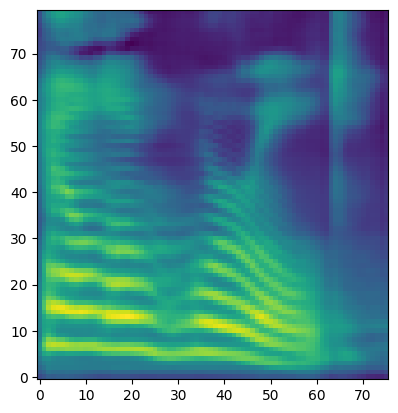

In [34]:
%matplotlib inline
if spec is not None:
    imshow(spec, origin="lower")
    plt.show()

Let's sum it all up!

Use these:

spec_gen.parse(str_input)

spec_gen.generate_spectrogram(tokens=parsed)

vocoder.convert_spectrogram_to_audio(spec=spectrogram)

In [35]:
str_input = "Congratulations! Fastest TTS ever in 7 lines of code"

In [ ]:
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

spec_gen = SpectrogramGenerator.from_pretrained("tts_en_tacotron2").eval().cuda()
vocoder = Vocoder.from_pretrained("tts_waveglow", strict=False)

with torch.no_grad():
    parsed = ...
    spectrogram = ...
    audio2 = ...

In [37]:
ipd.Audio(audio2.to('cpu').numpy(), rate=22050)